This script calculates EVI from Harmonized Landsat and Sentinel-2 Data for Nigeria

In [1]:
import time
start_time = time.time()


## 1. Getting Started<a id="getstarted"></a>

### 1.1 Import Packages

Import the required packages.

In [2]:
# Load all the libraries
import os
import numpy as np
import dask.distributed
import pystac_client
import geopandas as gpd
import odc.stac
import xarray as xr
import rasterio as rio
import rioxarray as rxr
import earthaccess
import hvplot.xarray

### 1.2 Earthdata Login Authentication

We will use the `earthaccess` package for authentication. `earthaccess` can either create a a new local `.netrc` file to store credentials or validate that one exists already in you user profile. If you do not have a `.netrc` file, you will be prompted for your credentials and one will be created.

In [3]:
# Log into earthaccess - ensures creation of .netrc file
earthaccess.login(persist=True)

### 1.3 Set up Dask Client

Here we set up a local `dask` cluster, which will define tasks based on our lazy loaded data and functions, then split those tasks accross our locally available threads or workers to improve process efficiency. You can view the dashboard by clicking the link and see various dashboards and monitor them as you run future cells.

In [4]:
# Initialize Dask Client
client = dask.distributed.Client()
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63975,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:63988,Total threads: 2
Dashboard: http://127.0.0.1:63990/status,Memory: 3.20 GiB
Nanny: tcp://127.0.0.1:63978,


2025-07-10 20:00:58,378 - distributed.scheduler - WARNING - Worker failed to heartbeat for 312s; attempting restart: <WorkerState 'tcp://127.0.0.1:63988', name: 0, status: running, memory: 0, processing: 0>
2025-07-10 20:00:58,401 - distributed.scheduler - WARNING - Worker failed to heartbeat for 312s; attempting restart: <WorkerState 'tcp://127.0.0.1:63989', name: 1, status: running, memory: 0, processing: 0>
2025-07-10 20:00:58,403 - distributed.scheduler - WARNING - Worker failed to heartbeat for 312s; attempting restart: <WorkerState 'tcp://127.0.0.1:63994', name: 4, status: running, memory: 0, processing: 0>
2025-07-10 20:00:58,404 - distributed.scheduler - WARNING - Worker failed to heartbeat for 312s; attempting restart: <WorkerState 'tcp://127.0.0.1:63997', name: 2, status: running, memory: 0, processing: 0>
2025-07-10 20:00:58,405 - distributed.scheduler - WARNING - Worker failed to heartbeat for 312s; attempting restart: <WorkerState 'tcp://127.0.0.1:64000', name: 3, status: 

### 1.4 Configure GDAL Options and rio environment

In [5]:
# Configure odc.stac rio env - requires a .netrc file, sends info to dask client
odc.stac.configure_rio(cloud_defaults=True,
                       verbose=True,
                       client=client,
                       GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',
                       GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/cookies.txt'),
                       GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/cookies.txt'))

GDAL_DATA                    = /Users/hephzibahadeniji/miniconda3/envs/lpdaac_vitals/share/gdal
GDAL_DISABLE_READDIR_ON_OPEN = EMPTY_DIR
GDAL_HTTP_MAX_RETRY          = 10
GDAL_HTTP_RETRY_DELAY        = 0.5
GDAL_HTTP_COOKIEFILE         = /Users/hephzibahadeniji/cookies.txt
GDAL_HTTP_COOKIEJAR          = /Users/hephzibahadeniji/cookies.txt


## 2. CMR-STAC Search<a id="find"></a>

To find HLS data, we will use the `pystac_client` python library to search [NASA's Common Metadata Repository SpatioTemporal Asset Catalog (CMR-STAC)](https://cmr.earthdata.nasa.gov/stac/docs/index.html#tag/STAC) for HLS data. We will use a geojson file containing our region of interest (ROI) to search for files that intersect. For this use case, our ROI is an agricultural field in Northern California.

In [6]:
# Open ROI polygon
roi = gpd.read_file("../../data/Boundary_VaccStates_Export/Boundary_VaccStates_Export.shp")

Add the collection, datetime range, results limit, and simplify our ROI to a bounding box and store these as search parameters. After defining these, conduct a stac search using the `LPCLOUD` STAC endpoint and return our query as a list of items.

In [7]:
catalog = pystac_client.Client.open("https://cmr.earthdata.nasa.gov/stac/LPCLOUD")
# Define search parameters
search_params = {
    "collections": ["HLSS30_2.0","HLSL30_2.0"],
    "bbox": tuple(list(roi.total_bounds)),
    "datetime": "2015-01-01/2015-12-31", #for all months in 2015
    "limit": 100,
}
# Perform the search
query = catalog.search(**search_params)
items = query.items()

In [8]:
items = list(query.items())
print(f"Found: {len(items):d} granules")

Found: 6887 granules


We can preview what these results look like.

In [9]:
items[0]

<Item id=HLS.L30.T32PNA.2015001T094225.v2.0>

To stack the data from both Landsat and Sentinel instruments, we need common band names for HLSL30 B5 (NIR) and HLSS30 B8A (NIR). We can simply rename them NIR in the stac results.

In [10]:
# Rename HLSS B8A and HLSL B05 to common band name
for item in items:
    if "HLS.L30" in item.id:
        item.assets["NIR"] = item.assets.pop("B05")
    if "HLS.S30" in item.id:
        item.assets["NIR"] = item.assets.pop("B8A")


In [11]:
# Confirm this changed the stac results
items[0]

<Item id=HLS.L30.T32PNA.2015001T094225.v2.0>

## 3. Opening Data with ODC-STAC<a id="odcstac"></a>

Use the `odc.stac.stac_load` function to load the data from the STAC results lazily into a dataset. To do this, we must provide a crs, a list of STAC results, a tuple of the bands we want to load, an expected resolution, and a dask chunk size.

In [12]:
# Set CRS and resolution, open lazily with odc.stac
crs = "utm"
ds = odc.stac.stac_load(
    items,
    bands=("B02", "B04","NIR", "Fmask"),
    crs=crs,
    resolution=30,
    chunks={"band":1,"x":512,"y":512},  # If empty, chunks along band dim, 
    #groupby="solar_day", # This limits to first obs per day
)
display(ds)

<xarray.Dataset> Size: 43TB
Dimensions:      (y: 40715, x: 48137, time: 1386)
Coordinates:
  * y            (y) float64 326kB 1.611e+06 1.611e+06 ... 3.898e+05 3.897e+05
  * x            (x) float64 385kB -2.667e+05 -2.666e+05 ... 1.177e+06 1.177e+06
    spatial_ref  int32 4B 32632
  * time         (time) datetime64[ns] 11kB 2015-01-01T09:42:25.764000 ... 20...
Data variables:
    B02          (time, y, x) float32 11TB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B04          (time, y, x) float32 11TB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    NIR          (time, y, x) float32 11TB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    Fmask        (time, y, x) float32 11TB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>

We can preview the size and shapes of the data we have loaded using the `geobox` function.

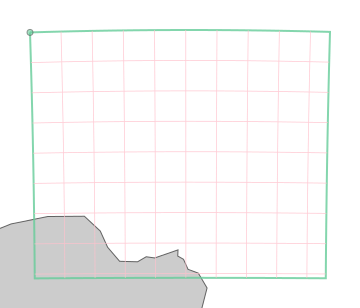

In [13]:
# Show Geobox
ds.odc.geobox

Next, we will clip the data to our ROI using the `rio.clip` function. This will continue to work lazily on the data, so we have yet to actually load any data.

In [14]:
# Clip
ds = ds.rio.clip(roi.geometry.values, roi.crs, all_touched=True)

2025-07-10 20:00:58,989 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/Users/hephzibahadeniji/miniconda3/envs/lpdaac_vitals/lib/python3.12/site-packages/distributed/comm/tcp.py", line 226, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/hephzibahadeniji/miniconda3/envs/lpdaac_vitals/lib/python3.12/site-packages/distributed/worker.py", line 1267, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hephzibahadeniji/miniconda3/envs/lpdaac_vitals/lib/python3.12/site-packages/distributed/utils_comm.py", line 416, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/Users/hep

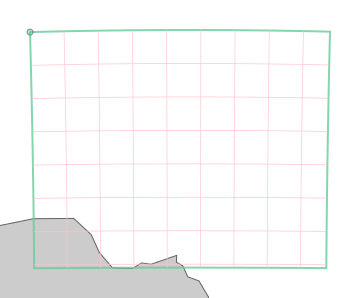

In [15]:
# Show Clipped Geobox
ds.odc.geobox

The `scale_factor` information in some of the HLSL30 granules are found in the file metadata, but missing from the Band metadata, meaning this isn't applied automatically. Manually scale each of the data arrays by the scale factor.

In [16]:
# Scale the data
ds.NIR.data = 0.0001 * ds.NIR.data
ds.B04.data = 0.0001 * ds.B04.data
ds.B02.data = 0.0001 * ds.B02.data

Now that we have clipped and scaled our data, we can load the minimal subset of data we need to calculate our EVI over our time period of interest.

In [ ]:
ds.load()

2025-07-10 20:13:09,780 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/Users/hephzibahadeniji/miniconda3/envs/lpdaac_vitals/lib/python3.12/site-packages/distributed/comm/tcp.py", line 226, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/hephzibahadeniji/miniconda3/envs/lpdaac_vitals/lib/python3.12/site-packages/distributed/worker.py", line 1267, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hephzibahadeniji/miniconda3/envs/lpdaac_vitals/lib/python3.12/site-packages/distributed/utils_comm.py", line 416, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/Users/hep

Plot the NIR data to ensure our scaling and clipping worked as expected. We can use the slide bar to scroll through the time dimension showing the 

In [ ]:
# Plot to ensure scaling worked
#ds.NIR.hvplot.image(x="x", y="y", groupby="time", cmap="viridis", width=600, height=500, crs='EPSG:4326', tiles='ESRI', rasterize=True)

#changed EPSG from 32610 to 4326

## 4. Calculate EVI<a id="calcevi"></a>

Now we can build an Enhanced Vegetation Index (EVI) dataset using the EVI formula:

$$
\text{EVI} = G \cdot \frac{\text{NIR} - \text{Red}}{\text{NIR} + C_1 \cdot \text{Red} - C_2 \cdot \text{Blue} + L}
$$

**NIR**: Near-Infrared reflectance.  
**Red**: Reflectance in the red band.  
**Blue**: Reflectance in the blue band, used primarily to correct for aerosol influences.  
**G**: Gain factor (often set to 2.5) that scales the index.  
**C₁**: Coefficient for the aerosol resistance term using the red band (commonly 6).  
**C₂**: Coefficient for the aerosol resistance term using the blue band (commonly 7.5).  
**L**: Canopy background adjustment, which helps to minimize soil brightness influences (commonly 1).  

We will use the typical values adopted for the MODIS algorithm for G, C1, C2 and L. The output values will range from -1 to 1 and indicate strength of vegetation signal, which correlates with biomass.

In [ ]:
# Calculate EVI
evi_ds = 2.5 * ((ds.NIR - ds.B04) / (ds.NIR + 6.0 * ds.B04 - 7.5 * ds.B02 + 1.0))

In [ ]:
evi_ds = evi_ds.compute()

Now lets visualize our EVI over our ROI. We can scroll through the time-series using the slider bar to the right of the figure.

In [ ]:
#evi_ds.hvplot.image(x="x", y="y", groupby="time", cmap="YlGn", clim=(0, 1), crs='EPSG:4326', tiles='ESRI', rasterize=True)

## 5. Quality Masking<a id="qualityfilter"></a>

Lastly, we will apply a function to our EVI dataset, which will mask out pixels based on our bit selection. 

For HLS v2.0 products, all quality information is included in the Fmask layer. This layer includes values corresponding to combinations of bits that represent
different quality descriptions at each location within the scene.  Bits are ordered `76543210` and correspond to the following quality descriptions:  

|Bit Number|Mask Name|Bit Value|Description|
|---|---|---|---|
|7-6|Aerosol<br>Level|11<br>10<br>01<br>00|High<br>Medium<br>Low<br>Clear<br>|
|5|Water|1<br>0|Yes<br>No|
|4|Snow/Ice|1<br>0|Yes<br>No|
|3|Cloud<br>Shadow|1<br>0|Yes<br>No|
|2|Cloud/Shadow<br>Adjacent|1<br>0|Yes<br>No|
|1|Cloud|1<br>0|Yes<br>No|
|0|Cirrus|Reserved|NA|

For example, an 8bit integer 224 converted to binary is 11100000. This would indicate high aerosol (bits 7-6), and water (bit 5) are present in a pixel with that value.

In [ ]:
def create_quality_mask(quality_data, bit_nums: list = [1, 2, 3, 4, 5]):
    """
    Uses the Fmask layer and bit numbers to create a binary mask of good pixels.
    By default, bits 1-5 are used.
    """
    mask_array = np.zeros((quality_data.shape[0], quality_data.shape[1]))
    # Remove/Mask Fill Values and Convert to Integer
    quality_data = np.nan_to_num(quality_data.copy(), nan=255).astype(np.int8)
    for bit in bit_nums:
        # Create a Single Binary Mask Layer
        mask_temp = np.array(quality_data) & 1 << bit > 0
        mask_array = np.logical_or(mask_array, mask_temp)
    return mask_array

Use xarray's `apply_ufunc` to apply a function in a vectorized way to our EVI timeseries dataset. `bit_nums` can be provided as a dict to specify which bits to mask out.

In [ ]:
quality_mask = xr.apply_ufunc(
    create_quality_mask,
    ds.Fmask,
    kwargs={"bit_nums": [1,2,3,4,5]},
    input_core_dims=[["x", "y"]],
    output_core_dims=[["x", "y"]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[np.bool],
)

Now use the `where` function to mask out regions corresponding with the bit numbers and visualize the EVI timeseries again.

In [ ]:
#evi_ds.where(~quality_mask).hvplot.image(x="x", y="y", groupby="time", cmap="YlGn", clim=(0, 1), crs='EPSG:4326', tiles='ESRI', rasterize=True)

In [ ]:
#Convert to Raster

import xarray as xr
import pandas as pd
import os

# Step 1: Group by month and compute monthly mean
monthly_evi = evi_ds.groupby("time.month").mean(dim="time", skipna=True)

# Optional: Give the DataArray a name for export
monthly_evi.name = "EVI"

# Set spatial dimensions and CRS if not already set
monthly_evi.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
monthly_evi.rio.write_crs("EPSG:4326", inplace=True)  # adjust if your CRS is different

# Step 2: Export each month as a separate raster
output_dir = "2015_evi_rasters_nigeria"
os.makedirs(output_dir, exist_ok=True)

for month in monthly_evi.month.values:
    evi_month = monthly_evi.sel(month=month)
    output_path = os.path.join(output_dir, f"EVI_month_{month:02d}.tif")
    evi_month.rio.to_raster(output_path)
    print(f"Exported: {output_path}")


In [ ]:
#Plot 
evi_month = rxr.open_rasterio("2015_evi_rasters_nigeria/EVI_month_06.tif", masked=True)

# Plot using hvplot (interactive)
evi_month.squeeze().hvplot.image(
    x="x", y="y", cmap="YlGn", title="Monthly Mean EVI - June",
    frame_width=600, frame_height=500, tiles='ESRI'
)

In [ ]:
# Your code across multiple cells- Timing
result = [x**2 for x in range(10**6)]
##

end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")


## Contact Info  

Email: LPDAAC@usgs.gov  
Voice: +1-866-573-3222  
Organization: Land Processes Distributed Active Archive Center (LP DAAC)¹  
Website: <https://lpdaac.usgs.gov/>  

¹Work performed under USGS contract G15PD00467 for NASA contract NNG14HH33I. 